In [233]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [234]:
from sklearn.impute import KNNImputer

In [235]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':5,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':2,
    'SEED':41
}

In [236]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [237]:
train_df = pd.read_csv('C:/Users/82108/Dacon/Cancer/open/train.csv')
test_df = pd.read_csv('C:/Users/82108/Dacon/Cancer/open/test.csv')

In [209]:
test_df = test_df.drop(['ID','img_path','수술연월일'], axis = 1)

In [213]:
test_df

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,0.149103,1,1,0,0.487959,2.0,2.0,3.0,2.0,1.0,...,1.0,8.0,0.0,2.0,5.00,0.0,1.0,NaN,NaN,NaN
1,-0.814797,3,1,0,-0.380249,3.0,2.0,2.0,3.0,1.0,...,1.0,4.0,1.0,8.0,8.67,0.0,0.0,NaN,NaN,NaN
2,1.835929,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,6.0,1.0,6.0,NaN,NaN,2.0,NaN,NaN,NaN
3,0.390078,0,1,0,-1.396053,2.0,2.0,3.0,2.0,1.0,...,1.0,7.0,0.0,NaN,21.17,1.0,3.0,NaN,NaN,0.0
4,0.229428,0,1,1,-0.206608,3.0,3.0,3.0,3.0,2.0,...,1.0,8.0,1.0,3.0,20.57,1.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.631053,0,0,0,0.053855,2.0,2.0,3.0,2.0,2.0,...,1.0,5.0,1.0,3.0,NaN,0.0,0.0,NaN,NaN,NaN
246,-0.895122,0,1,0,0.227497,1.0,2.0,3.0,2.0,1.0,...,1.0,5.0,1.0,5.0,NaN,0.0,1.0,NaN,NaN,NaN
247,-1.296747,0,0,0,-0.032966,1.0,1.0,3.0,1.0,1.0,...,1.0,5.0,1.0,5.0,NaN,0.0,0.0,NaN,NaN,NaN
248,-1.296747,0,0,0,-0.901174,1.0,1.0,2.0,1.0,1.0,...,1.0,5.0,1.0,5.0,NaN,0.0,0.0,NaN,NaN,NaN


In [136]:
train_df.columns

Index(['ID', 'img_path', 'mask_path', '나이', '수술연월일', '진단명', '암의 위치', '암의 개수',
       '암의 장경', 'NG', 'HG', 'HG_score_1', 'HG_score_2', 'HG_score_3',
       'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type', 'T_category', 'ER',
       'ER_Allred_score', 'PR', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2',
       'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio', 'BRCA_mutation',
       'N_category'],
      dtype='object')

In [137]:
train_df.isnull().sum()

ID                     0
img_path               0
mask_path              0
나이                     0
수술연월일                  0
진단명                    0
암의 위치                  0
암의 개수                  0
암의 장경                 69
NG                    51
HG                    86
HG_score_1            92
HG_score_2            92
HG_score_3            89
DCIS_or_LCIS_여부        0
DCIS_or_LCIS_type    874
T_category             4
ER                     1
ER_Allred_score      297
PR                     1
PR_Allred_score      453
KI-67_LI_percent     235
HER2                  14
HER2_IHC              24
HER2_SISH            753
HER2_SISH_ratio      825
BRCA_mutation        945
N_category             0
dtype: int64

In [141]:
train_df

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BC_01_3464,./train_imgs/BC_01_3464.png,-,65,2006-12-22,1,2,1,25.0,1.0,...,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1
996,BC_01_3482,./train_imgs/BC_01_3482.png,-,48,2006-11-17,1,1,1,7.0,1.0,...,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0
997,BC_01_3485,./train_imgs/BC_01_3485.png,-,64,2006-11-10,1,2,1,15.0,1.0,...,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1
998,BC_01_3502,./train_imgs/BC_01_3502.png,-,50,2006-09-22,1,1,1,7.0,1.0,...,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0


In [238]:
del_data = train_df[['ID','mask_path','수술연월일','img_path']]

In [239]:
del_data

,ID,mask_path,수술연월일,img_path
0,BC_01_0001,-,2015-10-23,./train_imgs/BC_01_0001.png
1,BC_01_0002,-,2015-10-28,./train_imgs/BC_01_0002.png
2,BC_01_0003,-,2015-10-29,./train_imgs/BC_01_0003.png
3,BC_01_0004,-,2016-03-08,./train_imgs/BC_01_0004.png
4,BC_01_0005,-,2015-10-30,./train_imgs/BC_01_0005.png
...,...,...,...,...
995,BC_01_3464,-,2006-12-22,./train_imgs/BC_01_3464.png
996,BC_01_3482,-,2006-11-17,./train_imgs/BC_01_3482.png
997,BC_01_3485,-,2006-11-10,./train_imgs/BC_01_3485.png
998,BC_01_3502,-,2006-09-22,./train_imgs/BC_01_3502.png


In [240]:
train_df = train_df.drop(['ID','img_path','mask_path','수술연월일','img_path'], axis = 1)

In [241]:
train_df.columns

Index(['나이', '진단명', '암의 위치', '암의 개수', '암의 장경', 'NG', 'HG', 'HG_score_1',
       'HG_score_2', 'HG_score_3', 'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type',
       'T_category', 'ER', 'ER_Allred_score', 'PR', 'PR_Allred_score',
       'KI-67_LI_percent', 'HER2', 'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio',
       'BRCA_mutation', 'N_category'],
      dtype='object')

In [242]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   나이                 1000 non-null   int64  
 1   진단명                1000 non-null   int64  
 2   암의 위치              1000 non-null   int64  
 3   암의 개수              1000 non-null   int64  
 4   암의 장경              931 non-null    float64
 5   NG                 949 non-null    float64
 6   HG                 914 non-null    float64
 7   HG_score_1         908 non-null    float64
 8   HG_score_2         908 non-null    float64
 9   HG_score_3         911 non-null    float64
 10  DCIS_or_LCIS_여부    1000 non-null   int64  
 11  DCIS_or_LCIS_type  126 non-null    float64
 12  T_category         996 non-null    float64
 13  ER                 999 non-null    float64
 14  ER_Allred_score    703 non-null    float64
 15  PR                 999 non-null    float64
 16  PR_Allred_score    547 no

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

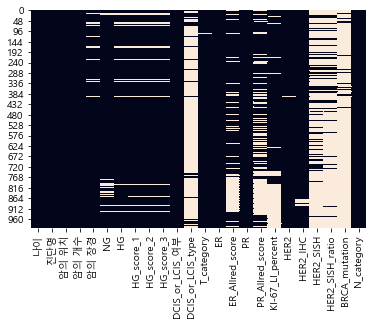

In [244]:
%matplotlib inline
sns.heatmap(train_df.isnull(), cbar = False)

In [245]:
imputer = KNNImputer(n_neighbors=5)

In [246]:
data_filled = pd.DataFrame(imputer.fit_transform(train_df))

In [247]:
data_filled.columns = ['나이', '진단명', '암의 위치', '암의 개수', '암의 장경', 'NG', 'HG', 'HG_score_1',
       'HG_score_2', 'HG_score_3', 'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type',
       'T_category', 'ER', 'ER_Allred_score', 'PR', 'PR_Allred_score',
       'KI-67_LI_percent', 'HER2', 'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio',
       'BRCA_mutation', 'N_category']

In [248]:
data_filled

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,63.0,1.0,2.0,1.0,19.0,2.0,1.0,2.0,2.0,1.0,...,8.0,1.0,6.0,12.000,0.0,1.0,0.0,1.312,0.4,0.0
1,51.0,1.0,1.0,1.0,22.0,3.0,3.0,3.0,3.0,3.0,...,4.8,0.0,5.0,70.000,0.0,0.0,0.0,1.336,0.8,1.0
2,37.0,1.0,2.0,1.0,14.4,2.0,1.6,2.4,1.4,1.4,...,7.0,1.0,4.0,7.000,0.0,1.0,0.2,1.376,0.0,0.0
3,54.0,1.0,2.0,1.0,0.0,3.0,3.0,3.0,3.0,2.0,...,7.0,0.0,6.0,1.000,1.0,3.0,0.2,2.750,0.0,0.0
4,57.0,1.0,2.0,1.0,8.0,2.0,2.0,3.0,2.0,1.0,...,8.0,0.0,6.4,8.000,1.0,2.0,1.0,5.440,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,65.0,1.0,2.0,1.0,25.0,1.0,1.0,2.0,1.0,1.0,...,7.2,0.0,6.8,20.246,0.0,0.0,0.0,1.350,0.0,1.0
996,48.0,1.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,...,6.8,1.0,5.0,7.528,0.0,0.0,0.0,2.110,0.0,0.0
997,64.0,1.0,2.0,1.0,15.0,1.0,1.0,2.0,1.0,2.0,...,7.8,1.0,6.6,2.862,0.0,0.0,0.0,1.182,0.4,1.0
998,50.0,1.0,1.0,1.0,7.0,1.0,1.0,1.0,2.0,1.0,...,6.2,0.0,6.4,5.242,0.0,0.0,0.0,2.164,0.0,0.0


In [249]:
data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   나이                 1000 non-null   float64
 1   진단명                1000 non-null   float64
 2   암의 위치              1000 non-null   float64
 3   암의 개수              1000 non-null   float64
 4   암의 장경              1000 non-null   float64
 5   NG                 1000 non-null   float64
 6   HG                 1000 non-null   float64
 7   HG_score_1         1000 non-null   float64
 8   HG_score_2         1000 non-null   float64
 9   HG_score_3         1000 non-null   float64
 10  DCIS_or_LCIS_여부    1000 non-null   float64
 11  DCIS_or_LCIS_type  1000 non-null   float64
 12  T_category         1000 non-null   float64
 13  ER                 1000 non-null   float64
 14  ER_Allred_score    1000 non-null   float64
 15  PR                 1000 non-null   float64
 16  PR_Allred_score    1000 n

<AxesSubplot:>

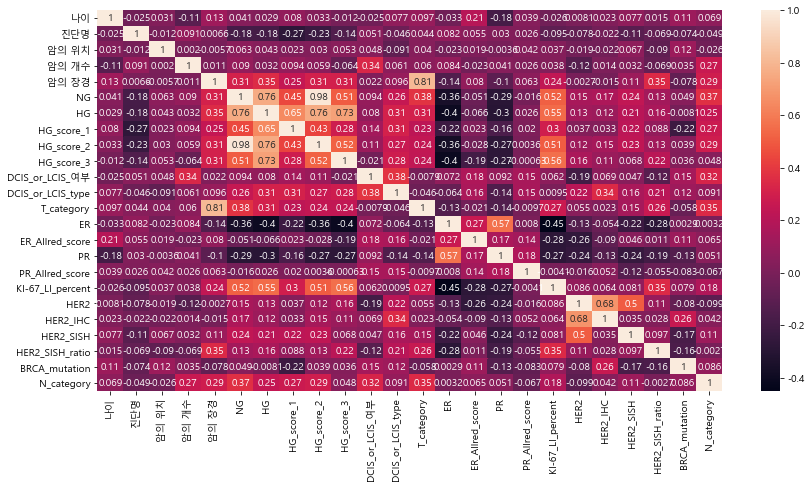

In [250]:
plt.figure(figsize = (14,7))
sns.heatmap(train_df.corr(), annot = True)

<AxesSubplot:>

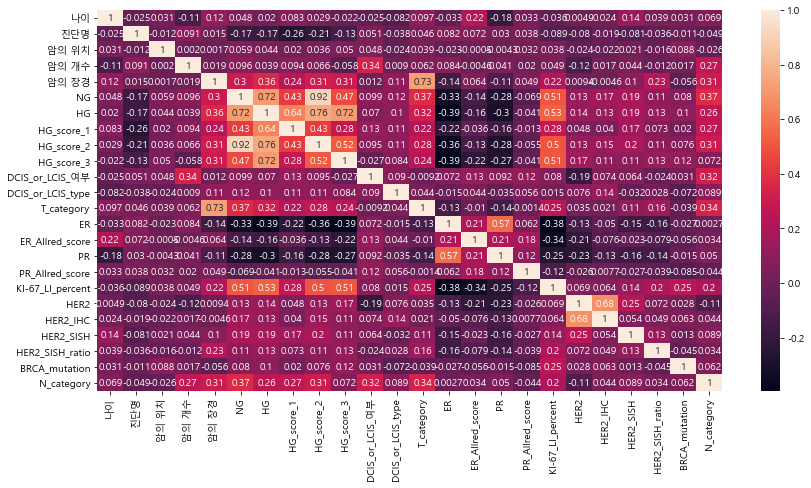

In [251]:
plt.figure(figsize = (14,7))
sns.heatmap(data_filled.corr(), annot = True)

In [252]:
int_list = ['BRCA_mutation','HER2_SISH','HER2_IHC','HER2',
            'KI-67_LI_percent','PR_Allred_score','PR','ER','T_category','ER_Allred_score',
            'DCIS_or_LCIS_여부','DCIS_or_LCIS_type','HG_score_2',
            'HG_score_1','HG','NG','HG_score_3']
for i in int_list:
    print(data_filled[i].value_counts())
    data_filled[i] = data_filled[i].round(0)
    print(data_filled[i].value_counts())
    data_filled[i] = data_filled[i].astype(int)
print(data_filled['HER2_SISH_ratio'].value_counts())
data_filled['HER2_SISH_ratio'] = data_filled['HER2_SISH_ratio'].round(2)
print(data_filled['HER2_SISH_ratio'].value_counts())    
data_filled[data_filled['PR_Allred_score'] > 8] = 8
data_filled[data_filled['HER2'] > 1] = 1

0.0    499
0.4    441
0.8     56
2.0      4
Name: BRCA_mutation, dtype: int64
0.0    940
1.0     56
2.0      4
Name: BRCA_mutation, dtype: int64
0.0    678
0.2    211
0.4     65
1.0     32
0.6     14
Name: HER2_SISH, dtype: int64
0.0    954
1.0     46
Name: HER2_SISH, dtype: int64
2.0    324
1.0    319
0.0    251
3.0     87
1.2      5
0.6      3
1.4      3
0.8      2
0.4      2
0.2      2
1.6      1
1.8      1
Name: HER2_IHC, dtype: int64
1.0    332
2.0    326
0.0    255
3.0     87
Name: HER2_IHC, dtype: int64
0.0    742
1.0    244
0.4      5
0.6      4
0.2      3
0.8      2
Name: HER2, dtype: int64
0.0    750
1.0    250
Name: HER2, dtype: int64
5.00     75
10.00    59
1.00     56
20.00    37
3.00     27
         ..
31.93     1
22.66     1
5.82      1
24.98     1
5.96      1
Name: KI-67_LI_percent, Length: 577, dtype: int64
5.0     102
10.0     86
1.0      65
20.0     50
3.0      42
       ... 
77.0      1
79.0      1
86.0      1
65.0      1
95.0      1
Name: KI-67_LI_percent, Length: 

In [253]:
int_type = ['나이','진단명','암의 위치','암의 개수','N_category']

In [254]:
data_filled[int_type] = data_filled[int_type].astype(int)

In [255]:
data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   나이                 1000 non-null   int32  
 1   진단명                1000 non-null   int32  
 2   암의 위치              1000 non-null   int32  
 3   암의 개수              1000 non-null   int32  
 4   암의 장경              1000 non-null   float64
 5   NG                 1000 non-null   int32  
 6   HG                 1000 non-null   int32  
 7   HG_score_1         1000 non-null   int32  
 8   HG_score_2         1000 non-null   int32  
 9   HG_score_3         1000 non-null   int32  
 10  DCIS_or_LCIS_여부    1000 non-null   int32  
 11  DCIS_or_LCIS_type  1000 non-null   int32  
 12  T_category         1000 non-null   int32  
 13  ER                 1000 non-null   int32  
 14  ER_Allred_score    1000 non-null   int32  
 15  PR                 1000 non-null   int32  
 16  PR_Allred_score    1000 n

In [256]:
train_data =  pd.concat([data_filled, del_data],axis=1)

In [258]:
train_data.to_csv("C:/Users/82108/Dacon/Cancer/open/train_data.csv", index = False)

In [159]:
train_df, val_df, train_labels, val_labels = train_test_split(
                                                    train_data.drop(columns=['N_category']), 
                                                    train_data['N_category'], 
                                                    test_size=0.2, 
                                                    random_state=CFG['SEED']
                                                )

In [212]:
def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))
        #test_df[col] = scaler.transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))
        #test_df[col] = le.transform(get_values(test_df[col]))

In [195]:
train_df_test = train_df.drop(['ID', 'img_path', 'mask_path', '수술연월일'],axis=1)
val_df_test =  val_df.drop(['ID', 'img_path', 'mask_path', '수술연월일'],axis=1)

In [182]:
from matplotlib import rc  ### 이 줄과
rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

import xgboost as xgb
from xgboost import plot_importance
import optuna

In [190]:
def RF_objective(trial: optuna.trial.Trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric':'auc',
        'booster':'gbtree',
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000, step=10),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        
        'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
        #"tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
        
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
        # 'scale_pos_weight': scale_pos_weight
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 5, 20, step=5)
        
        # "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
        # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
    }

    model = xgb.XGBClassifier(**params, random_state = 21, use_label_encoder = False, n_jobs=-1)
    
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=21)
    score = cross_val_score(model, train_df_test, train_labels, cv=cv, scoring="f1", n_jobs=-1)
    f1_mean = score.mean()

    return f1_mean

In [191]:
RF_study = optuna.create_study()
RF_study.optimize(RF_objective, n_trials=100)

[I 2022-11-18 13:42:31,377] A new study created in memory with name: no-name-3bc07e78-fcda-464f-a847-48a06b7f1d9f
[I 2022-11-18 13:42:36,452] Trial 0 finished with value: 0.749414106597226 and parameters: {'n_estimators': 290, 'max_depth': 8, 'gamma': 0.179504528172668, 'min_child_weight': 5, 'subsample': 0.9, 'colsample_bytree': 0.9988110063949474, 'colsample_bylevel': 0.5315680131710934, 'colsample_bynode': 0.9963659796446775, 'reg_lambda': 0.5847443378220933, 'reg_alpha': 0.14205797224921682}. Best is trial 0 with value: 0.749414106597226.
[I 2022-11-18 13:42:42,209] Trial 1 finished with value: 0.7639967671807042 and parameters: {'n_estimators': 530, 'max_depth': 5, 'gamma': 0.20141118314256432, 'min_child_weight': 5, 'subsample': 0.9, 'colsample_bytree': 0.9529166130018059, 'colsample_bylevel': 0.7972453479795898, 'colsample_bynode': 0.9219271914722151, 'reg_lambda': 0.04015053584510844, 'reg_alpha': 0.19600265485296425}. Best is trial 0 with value: 0.749414106597226.
[I 2022-11-1

[I 2022-11-18 13:44:14,960] Trial 18 finished with value: 0.7493561864834208 and parameters: {'n_estimators': 710, 'max_depth': 7, 'gamma': 0.6547708135709128, 'min_child_weight': 4, 'subsample': 0.65, 'colsample_bytree': 0.8281244067325012, 'colsample_bylevel': 0.5939533046986633, 'colsample_bynode': 0.9479037155036579, 'reg_lambda': 0.3526262937825063, 'reg_alpha': 0.2481585266728306}. Best is trial 9 with value: 0.7447468029080875.
[I 2022-11-18 13:44:18,301] Trial 19 finished with value: 0.7617562991978162 and parameters: {'n_estimators': 260, 'max_depth': 9, 'gamma': 0.37163732583419756, 'min_child_weight': 2, 'subsample': 0.75, 'colsample_bytree': 0.7719193411067189, 'colsample_bylevel': 0.757987803302884, 'colsample_bynode': 0.742862491954865, 'reg_lambda': 0.018214094543859444, 'reg_alpha': 0.6229575166180835}. Best is trial 9 with value: 0.7447468029080875.
[I 2022-11-18 13:44:26,881] Trial 20 finished with value: 0.7589188960904413 and parameters: {'n_estimators': 670, 'max_d

[I 2022-11-18 13:47:08,518] Trial 37 finished with value: 0.7424796396066091 and parameters: {'n_estimators': 800, 'max_depth': 5, 'gamma': 0.3327913210118127, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.9208353822975575, 'colsample_bylevel': 0.7003679238679368, 'colsample_bynode': 0.8838427316747643, 'reg_lambda': 0.03806919703446149, 'reg_alpha': 0.3460908050668937}. Best is trial 25 with value: 0.7291736768306869.
[I 2022-11-18 13:47:13,004] Trial 38 finished with value: 0.7685142414631565 and parameters: {'n_estimators': 610, 'max_depth': 7, 'gamma': 0.1741840352310802, 'min_child_weight': 5, 'subsample': 1.0, 'colsample_bytree': 0.9368414641884075, 'colsample_bylevel': 0.6353668812171246, 'colsample_bynode': 0.7049145566815455, 'reg_lambda': 0.10088627559961383, 'reg_alpha': 0.5159838039593293}. Best is trial 25 with value: 0.7291736768306869.
[I 2022-11-18 13:47:24,109] Trial 39 finished with value: 0.7583613531874014 and parameters: {'n_estimators': 1000, 'max

[I 2022-11-18 13:49:54,494] Trial 56 finished with value: 0.7273428153723273 and parameters: {'n_estimators': 890, 'max_depth': 7, 'gamma': 0.3249861336336985, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.9788573739991115, 'colsample_bylevel': 0.5645505563204747, 'colsample_bynode': 0.8926646112850144, 'reg_lambda': 0.021748598954211346, 'reg_alpha': 0.29442092467692604}. Best is trial 56 with value: 0.7273428153723273.
[I 2022-11-18 13:50:04,422] Trial 57 finished with value: 0.7550239017314444 and parameters: {'n_estimators': 950, 'max_depth': 7, 'gamma': 0.3156665697989616, 'min_child_weight': 3, 'subsample': 0.65, 'colsample_bytree': 0.9888818231441565, 'colsample_bylevel': 0.5150271257087016, 'colsample_bynode': 0.8944308666602683, 'reg_lambda': 0.017959775735095676, 'reg_alpha': 0.30101917595758065}. Best is trial 56 with value: 0.7273428153723273.
[I 2022-11-18 13:50:12,149] Trial 58 finished with value: 0.7473792885714434 and parameters: {'n_estimators': 780, 

[I 2022-11-18 13:53:05,085] Trial 75 finished with value: 0.7396208146932246 and parameters: {'n_estimators': 950, 'max_depth': 7, 'gamma': 0.479379207061019, 'min_child_weight': 5, 'subsample': 0.65, 'colsample_bytree': 0.7619295187453874, 'colsample_bylevel': 0.8595673814992162, 'colsample_bynode': 0.6435045523662645, 'reg_lambda': 0.1030748887099468, 'reg_alpha': 0.1400426292903317}. Best is trial 56 with value: 0.7273428153723273.
[I 2022-11-18 13:53:15,017] Trial 76 finished with value: 0.7404189296842838 and parameters: {'n_estimators': 920, 'max_depth': 7, 'gamma': 0.53078099034877, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.8608855307439899, 'colsample_bylevel': 0.9332911528241036, 'colsample_bynode': 0.5510144763709364, 'reg_lambda': 0.13383997208481904, 'reg_alpha': 0.1519843417808748}. Best is trial 56 with value: 0.7273428153723273.
[I 2022-11-18 13:53:25,519] Trial 77 finished with value: 0.7334411712476154 and parameters: {'n_estimators': 1000, 'max_de

[I 2022-11-18 13:55:58,173] Trial 94 finished with value: 0.7459301746274701 and parameters: {'n_estimators': 990, 'max_depth': 6, 'gamma': 0.41054400523965734, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.8386024169657638, 'colsample_bylevel': 0.8723733808285338, 'colsample_bynode': 0.5608821673094692, 'reg_lambda': 0.013363823998886885, 'reg_alpha': 0.2640976531630147}. Best is trial 56 with value: 0.7273428153723273.
[I 2022-11-18 13:56:08,636] Trial 95 finished with value: 0.7310894679456552 and parameters: {'n_estimators': 930, 'max_depth': 7, 'gamma': 0.4608326420365904, 'min_child_weight': 5, 'subsample': 0.6, 'colsample_bytree': 0.8010828875134284, 'colsample_bylevel': 0.8332966342430397, 'colsample_bynode': 0.7248253683346858, 'reg_lambda': 0.02121481079754398, 'reg_alpha': 0.21272233949788732}. Best is trial 56 with value: 0.7273428153723273.
[I 2022-11-18 13:56:19,031] Trial 96 finished with value: 0.7323007786921943 and parameters: {'n_estimators': 930, 'm

In [192]:
RF_study.best_params

{'n_estimators': 890,
 'max_depth': 7,
 'gamma': 0.3249861336336985,
 'min_child_weight': 5,
 'subsample': 0.6,
 'colsample_bytree': 0.9788573739991115,
 'colsample_bylevel': 0.5645505563204747,
 'colsample_bynode': 0.8926646112850144,
 'reg_lambda': 0.021748598954211346,
 'reg_alpha': 0.29442092467692604}

In [193]:
rfc = xgb.XGBClassifier(**RF_study.best_params, objective='binary:logistic', eval_metric='auc', booster='gbtree', random_state = 21, use_label_encoder = False, n_jobs=-1)

In [196]:
rfc.fit(train_df_test, train_labels)     


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5645505563204747,
              colsample_bynode=0.8926646112850144,
              colsample_bytree=0.9788573739991115, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.3249861336336985, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=890, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=21, ...)

In [197]:
y_pred = rfc.predict(val_df_test)


In [198]:
print(classification_report(val_labels, y_pred, target_names=['No Frauds', 'Frauds']))     #  X_train, X_test, y_train, y_test


              precision    recall  f1-score   support

   No Frauds       0.66      0.70      0.68       100
      Frauds       0.68      0.64      0.66       100

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.67      0.67      0.67       200



In [199]:
classification_report(val_labels, y_pred, target_names=['No Frauds', 'Frauds'], output_dict=True)


{'No Frauds': {'precision': 0.660377358490566,
  'recall': 0.7,
  'f1-score': 0.6796116504854369,
  'support': 100},
 'Frauds': {'precision': 0.6808510638297872,
  'recall': 0.64,
  'f1-score': 0.6597938144329897,
  'support': 100},
 'accuracy': 0.67,
 'macro avg': {'precision': 0.6706142111601766,
  'recall': 0.6699999999999999,
  'f1-score': 0.6697027324592133,
  'support': 200},
 'weighted avg': {'precision': 0.6706142111601767,
  'recall': 0.67,
  'f1-score': 0.6697027324592133,
  'support': 200}}

In [200]:
f1score = classification_report(val_labels, y_pred, target_names=['No Frauds', 'Frauds'], output_dict=True)['macro avg']['f1-score']
f1score

0.6697027324592133

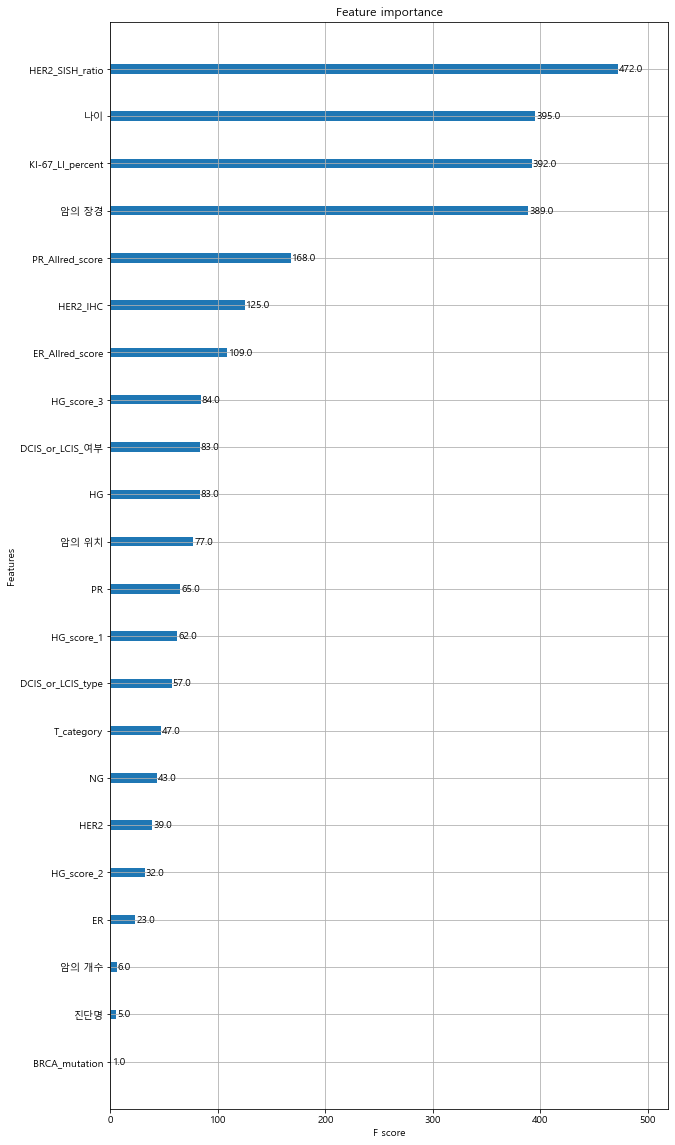

In [201]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') 

fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(rfc, ax=ax)
plt.show()

In [203]:
# make predictions for test data
y_pred = rfc.predict(val_df_test)
predictions = [round(value) for value in y_pred]

In [205]:
# evaluate predictions
mean_squared_error(val_labels, y_pred)

0.33

In [206]:
# accuracy
accuracy = accuracy_score(val_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.00%


In [219]:
test_df

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,0.149103,1,1,0,0.487959,2.0,2.0,3.0,2.0,1.0,...,1.0,8.0,0.0,2.0,5.00,0.0,1.0,NaN,NaN,NaN
1,-0.814797,3,1,0,-0.380249,3.0,2.0,2.0,3.0,1.0,...,1.0,4.0,1.0,8.0,8.67,0.0,0.0,NaN,NaN,NaN
2,1.835929,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,6.0,1.0,6.0,NaN,NaN,2.0,NaN,NaN,NaN
3,0.390078,0,1,0,-1.396053,2.0,2.0,3.0,2.0,1.0,...,1.0,7.0,0.0,NaN,21.17,1.0,3.0,NaN,NaN,0.0
4,0.229428,0,1,1,-0.206608,3.0,3.0,3.0,3.0,2.0,...,1.0,8.0,1.0,3.0,20.57,1.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.631053,0,0,0,0.053855,2.0,2.0,3.0,2.0,2.0,...,1.0,5.0,1.0,3.0,NaN,0.0,0.0,NaN,NaN,NaN
246,-0.895122,0,1,0,0.227497,1.0,2.0,3.0,2.0,1.0,...,1.0,5.0,1.0,5.0,NaN,0.0,1.0,NaN,NaN,NaN
247,-1.296747,0,0,0,-0.032966,1.0,1.0,3.0,1.0,1.0,...,1.0,5.0,1.0,5.0,NaN,0.0,0.0,NaN,NaN,NaN
248,-1.296747,0,0,0,-0.901174,1.0,1.0,2.0,1.0,1.0,...,1.0,5.0,1.0,5.0,NaN,0.0,0.0,NaN,NaN,NaN


In [220]:
y_pred = rfc.predict(test_df)

In [227]:
submission = pd.read_csv('C:/Users/82108/Dacon/Cancer/sample_submission.csv')

In [229]:
submission['N_category'] = y_pred

In [231]:
submission.to_csv("C:/Users/82108/Dacon/Cancer/XGB_Do_Not_Submit.csv", index = False)

In [230]:
submission

,ID,N_category
0,BC_01_0011,1
1,BC_01_0220,1
2,BC_01_0233,0
3,BC_01_0258,1
4,BC_01_0260,1
...,...,...
245,BC_01_3328,1
246,BC_01_3404,1
247,BC_01_3418,1
248,BC_01_3438,0
